In [1]:
import numpy as np 
from scipy.signal import tukey, welch, convolve
from gw_search_functions import *
import matplotlib.pyplot as plt
import os

In [2]:
RUN_TYPE = 'test' # change to 'prod'

In [3]:
if not os.path.exists('build'):
    os.makedirs('build')

output_filetypes = ['png', 'pdf']

In [4]:
f_sampling = 4096 # Hz

# Question 1
Load the time domain data and Fourier transform it.

Hint: 
To avoid edge effects, before performing the (real) FFT of the data, apply a smooth window,
meaning multiply by a function that gradually zeros at the ends. It is recommended to use a
Tukey window with parameter 0.1 (see scipy.signal.tukey).

In [5]:
strain = np.load('strain.npy')
strain *=  tukey(len(strain), alpha=0.1)
strain_fft = np.fft.rfft(strain)
frequencies = np.fft.rfftfreq(len(strain), 1/f_sampling)

/tmp/ipykernel_7583/2654836969.py:2: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  strain *=  tukey(len(strain), alpha=0.1)


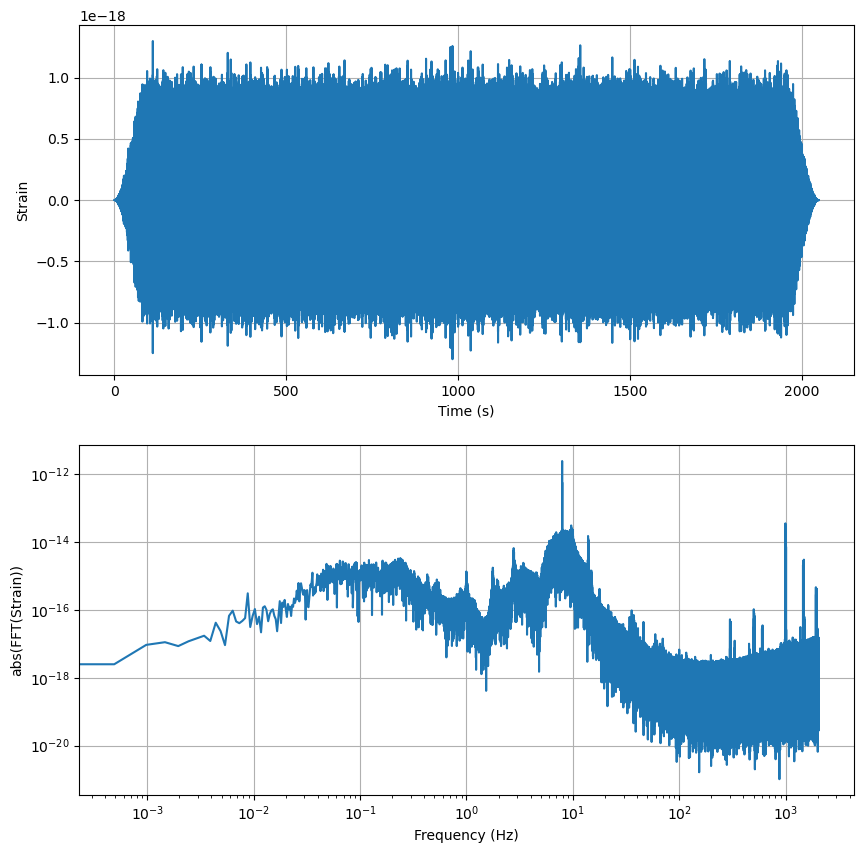

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(times, strain)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Strain')

axes[1].plot(frequencies, np.abs(strain_fft))
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('abs(FFT(Strain))')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

for ax in axes:
    ax.grid()

# Question 2
Estimate the ASD and create the whitening filter. Create a log-log plot of the ASD
from 20Hz onward. Create a log-log plot of the whitening filter from 20Hz
onward. Plot the entire whitened strain data.

Hints: 

Use the Welch method (see scipy.signal.welch) to estimate the ASD of the data. This function
divides data into slices, perform an FFT on each, and averages over the squared absolute value
per frequency. Use slices of 64 seconds, with overlaps of 50% between the slices. Use median
averaging to be less sensitive to outliers (such as glitches). The function will apply a window
to the slices by default.

Note that the estimated ASD frequency resolution is defined by the window length. Interpolate
it (in frequency domain) so it will be defined on the same frequency axis as the strain.

The whitening window is roughly the inverse of the ASD, except it is also high-passed above
20Hz. The high-pass filter should be smooth, e.g. zero below 20Hz, one above 21Hz, and
gradually increasing between 20Hz and 21Hz like sine-squared.

In [7]:
def smoothed_step(x, a, b):
    """
    Smoothed step function.
    
    Parameters:
    x : float or array-like
        Input value or array of input values.
    a : float
        Lower bound where the function starts to rise.
    b : float
        Upper bound where the function reaches 1.
    
    Returns:
    float or array-like
        Output value or array of output values after applying the smoothed step function.
    """
    x = np.asarray(x)
    y = np.zeros_like(x)
    y[x >= b] = 1
    mask = (x > a) & (x < b)
    y[mask] = (x[mask] - a) / (b - a)
    return y


def whitening_filter(asd, frequencies, highpass=(20,21)):
    """
    Applies a whitening filter to the ASD values across the given frequencies.
    
    Parameters:
    asd : array-like
        Amplitude spectral density values.
    frequencies : array-like
        Corresponding frequency values.
    highpass : tuple of two floats, optional
        Frequencies defining the highpass filter transition region.
        Returns 0 if f < first value, 1/asd if f > second value, and
        a smoothed transition between them.
    
    Returns:
    array-like
        Whitening filter values applied to the ASD values.
    """
    asd = np.asarray(asd)
    frequencies = np.asarray(frequencies)
    filter_values = np.zeros_like(frequencies)

    filter_values = 1 / asd
    
    if highpass:
        f1, f2 = highpass
        filter_values *= smoothed_step(frequencies, f1, f2)
    
    return filter_values    

In [50]:
def welch_wrapper(data, interpolation=False):
    """
    Wrapper function for the Welch method.
    
    Parameters:
    data : array-like
        Input data to compute the power spectral density.
    
    Returns:
    tuple of array-like
        Frequency values and power spectral density values.
    """
    if len(data) != len(strain):
        raise Warning('The data length should probably match the strain length.')
     
    f, psd = welch(data, 
                   fs=f_sampling, 
                   nperseg=f_sampling * 64,
                   average='median',
                   window='hann',
                   scaling='spectrum')
    
    psd /= 2 # account for single-sided spectrum
    
    if interpolation:
        psd = np.interp(frequencies, f, psd)
        return frequencies, psd
    
    return f, psd

In [45]:
# Welch gives psd -> asd = sqrt(psd) -> whitening filter = 1/sqrt(psd) = 1/asd
frequencies_welch, psd = welch_wrapper(strain, interpolation=True)
asd = np.sqrt(psd)
W = whitening_filter(asd, frequencies)

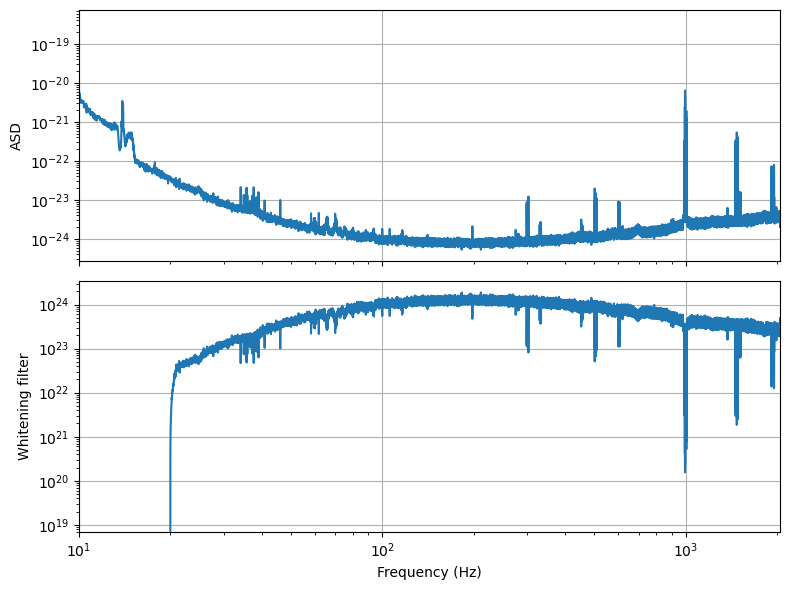

In [34]:
# put it all in a subfigure
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax = axes[0]
ax.plot(frequencies, asd)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('ASD')

ax = axes[1]
ax.plot(frequencies, W)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Whitening filter')

for ax in axes:
    ax.grid()
    ax.set_xlim(10, frequencies_welch.max())

plt.tight_layout()

if RUN_TYPE == 'prod':
    fn = 'build/Q2_loglog_fourier'

    for filetype in output_filetypes:
        fig.savefig(f'{fn}.{filetype}')
    


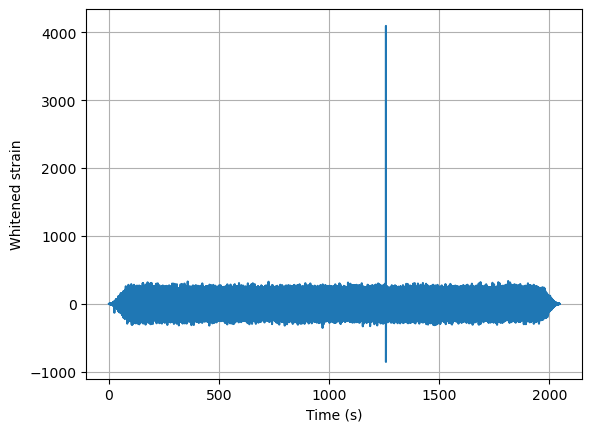

In [10]:
# Apply whitening filter to data in frequency domain
whitened_data_fft = strain_fft * W
whitened_data = np.fft.irfft(whitened_data_fft)
plt.plot(times, whitened_data)
plt.xlabel('Time (s)')
plt.ylabel('Whitened strain')
plt.grid()

# Question 3

Create a single template for a search, with arbitrarily selected masses of 1 = 1.5 and
2 = 1.25 (in solar masses). Plot the time-domain template, such that it is localized
in the middle of the time-axis. Fix the plot such that the waveform features are
visible.

In [11]:
m1 = 1.5
m2 = 1.25 


phases = masses_to_phases(m1, m2, frequencies)
h_fft = frequencies ** (-7/6) * np.exp(1j * phases)

# shift in phase (fourier) -> shift in time (real)
#shift_time = times[-1] / 2 
shift_time = times[-1] * 3/ 4 
phase_shift = np.exp(-1j * 2 * np.pi * frequencies * shift_time)
h_fft = h_fft * phase_shift

# high pass filter
h_fft[frequencies < 20] = 0
h_fft *= W

h_fft /= np.sqrt(correlate(h_fft,h_fft)) # do not pass whitening filter because we applied it already (its \tilde{h})

h = np.fft.irfft(h_fft)

/tmp/ipykernel_7583/2457091478.py:6: RuntimeWarning: divide by zero encountered in power
  h_fft = frequencies ** (-7/6) * np.exp(1j * phases)
/tmp/ipykernel_7583/2457091478.py:6: RuntimeWarning: invalid value encountered in multiply
  h_fft = frequencies ** (-7/6) * np.exp(1j * phases)


/tmp/ipykernel_7583/3691521050.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


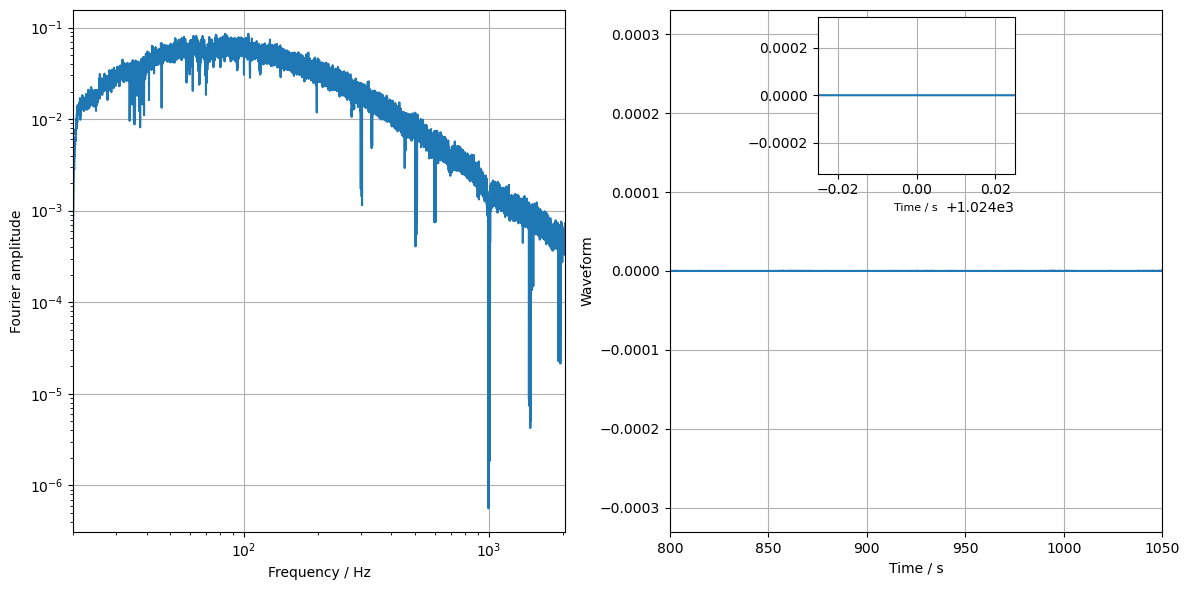

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming `strain`, `frequencies`, `h_fft`, `times`, and `h` are already defined as per your code

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: Fourier amplitude
ax = axes[0]
ax.plot(frequencies, np.abs(h_fft))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(20,2048)
ax.set_xlabel('Frequency / Hz')
ax.set_ylabel('Fourier amplitude')
ax.grid()

# Right plot: Time-domain waveform
ax = axes[1]
ax.plot(times, h)
ax.set_xlim(800, 1050)
ax.set_xlabel('Time / s')
ax.set_ylabel('Waveform')
ax.grid()

# Add inset plot
inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper center')
inset_ax.plot(times, h)
event_time = times[-1] / 2
scale = 0.025
inset_ax.set_xlim(event_time - scale, event_time + scale)  # Adjust as needed to zoom into the feature
#inset_ax.set_ylim(-1e-5, 1e-5)  # Adjust as needed to zoom into the feature
inset_ax.set_xlabel('Time / s', fontsize=8)
inset_ax.grid()

fig.tight_layout()
plt.show()

if RUN_TYPE == 'prod':
    fn = 'build/Q2_waveform'

    for filetype in output_filetypes:
        fig.savefig(f'{fn}.{filetype}')

# Question 4

Generate the complex-overlap time-series. Plot a histogram with the real and imaginary parts of the complex-overlap, at a segment of data without an obvious
glitch. Overlay the theoretical predictions.

In [71]:
# sample random noise based on PSD
def noise_sample_from_psd(frequencies, psd, high_pass=None):
    if len(psd) != len(frequencies):
        raise ValueError('PSD and frequencies must have the same length')
    
    white_noise_freq = np.random.normal(0, psd / 2, len(psd)) + 1j * np.random.normal(0, psd / 2, len(psd))

    if high_pass is None:
        return white_noise_freq
    
    # highpass with smooth step
    white_noise_freq[frequencies < high_pass[0]] = 0
    white_noise_freq *= smoothed_step(frequencies, high_pass[0], high_pass[1])
    
    return white_noise_freq

In [82]:
noise_sample_fft = noise_sample_from_psd(frequencies, psd)
noise_sample = np.fft.irfft(noise_sample_fft, norm='forward')

In [83]:
# to see if the noise is correct 
frequencies_welch, psd_welch = welch_wrapper(noise_sample, interpolation=True)


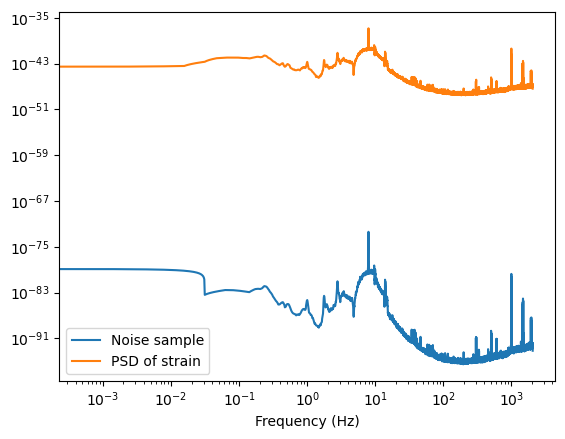

In [84]:
plt.plot(frequencies, psd_welch, label='Noise sample')
plt.plot(frequencies, psd, label='PSD of strain')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Frequency (Hz)')

plt.legend()

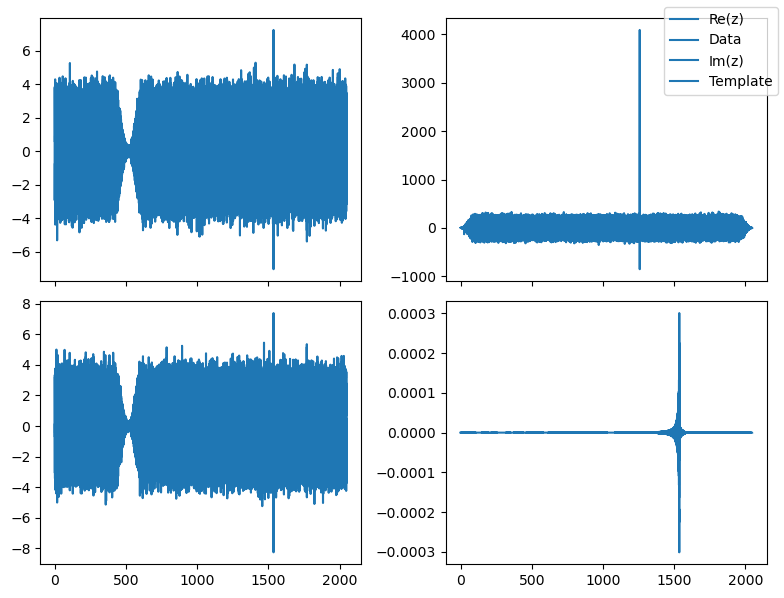

In [14]:
z = get_complex_overlap_timeseries(h_fft, whitened_data_fft)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

axes[0,0].plot(times, z.real, label='Re(z)')
axes[1,0].plot(times, z.imag, label='Im(z)')

axes[0,1].plot(times, whitened_data, label='Data')
axes[1,1].plot(times, h, label='Template')

fig.legend()
fig.tight_layout()

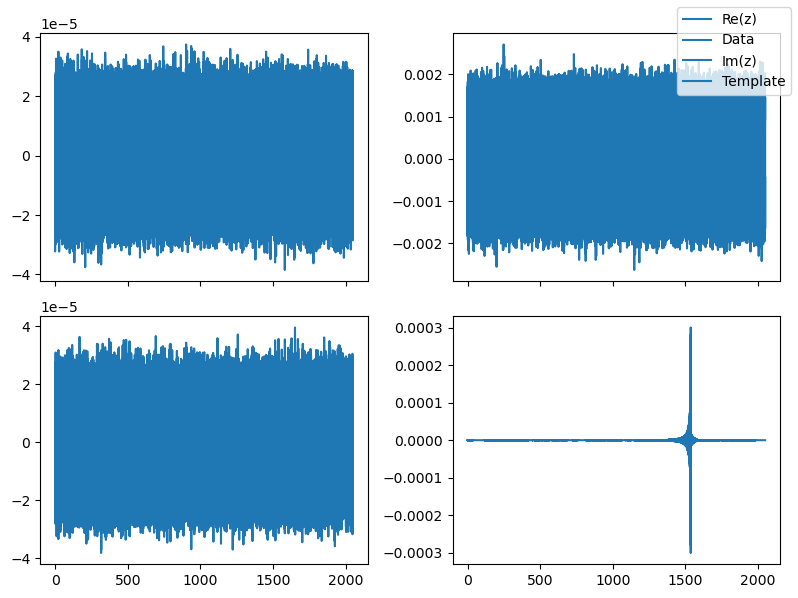

In [15]:
d_fft = noise_sample_fourier(frequencies, smoothed_step(frequencies, 20, 21), high_pass=None)
d = np.fft.irfft(d_fft)
z = get_complex_overlap_timeseries(h_fft, d_fft)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

axes[0,0].plot(times, z.real, label='Re(z)')
axes[1,0].plot(times, z.imag, label='Im(z)')

axes[0,1].plot(times, d, label='Data')
axes[1,1].plot(times, h, label='Template')

fig.legend()
fig.tight_layout()

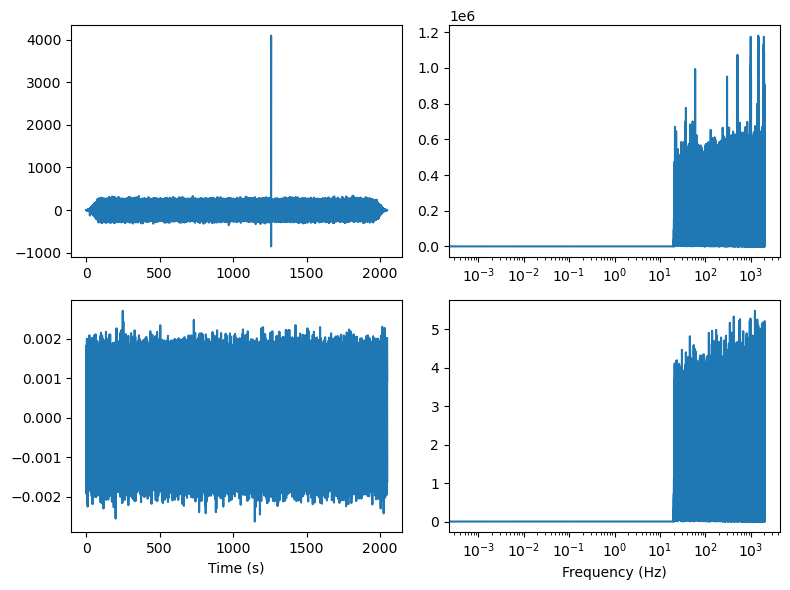

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

axes[0,0].plot(times, whitened_data)
axes[1,0].plot(times, d)

axes[0,1].plot(frequencies, np.abs(whitened_data_fft))
axes[1,1].plot(frequencies, np.abs(d_fft))

axes[1,0].set_xlabel('Time (s)')
axes[1,1].set_xlabel('Frequency (Hz)')

axes[1,1].set_xscale('log')
axes[0,1].set_xscale('log')

fig.tight_layout()

# Question 5

# Question 6